<h1> Thomas M. Boudreaux</h1>
<h2> Computational Physics Project 3</h2>
<h2> December 3 2018</h2>

<h3>Indroduction</h3>
Here I present a simple model of a pressurized ballon. This is achived through the numerical integration of "ballon" particles and "gas particles". Each ballon particles is connected to two other ballon particles by a spring potential, the set of all ballon particles is arranged in a circle. The gas particles ineract with the other gas particles through a lenard-jones potential. Finally the ballon and gas particles interact with one and other via a spring potential when they are within a certain charecaristic radius of one and other. The model is presented in full bellow
$$
F_{\text{ballon-ballon}} = -k_{b}[(r_{i+1}-r_{i})-s_{b}]-k_{b}[(r_{i-1}-r_{i})-s_{c}] \\
F_{\text{gas-gas}} = \sum_{i=0}^{n_{g}}\epsilon\left[\left(\frac{r_{m}}{r-r_{i}}\right)^{2}-2\left(\frac{r_{m}}{r-r_{i}}\right)^{6}\right] \\
F_{\text{gas-ballon}} = -\sum_{i=0}^{n_{g}}k_{g}[(r-r_{b,j})-s_{g}]
$$

In order to model an inward pressure the value of equilibrium length of the springs connecting the ballons is set to be an order of magnitude smaller than the the initial seperation of the ballon masses. This places an effective pressure along the surface of the ballon.

Additionally due to the large number of particles required to effectivly see pressurization the n-body integrator implimented with the traditional CPython interpriter and numpy prooved to be quite slow. This was remidied using the just-in-time compiler "numba". The effect of this is an approximate 300 times speed improvment over the origional python implimentation.

We start with importing the required libraries. If you do not have numba installed this will fail. The recommended manner of installing numba is through the anaconda python stack, however you may also install it with your operating systems package manager so long as you also have llmv or llvm-lite installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mplEasyAnimate import animation
from tqdm import tqdm
from scipy.special import comb
from scipy.special import factorial
from numba import njit, jit

Now we define a function to calculate the lenard-jones potential. Note here the @njit decorator. This tells the numba just-in-time compiler to compile this function in no python mode.

In [2]:
@njit
def lenjones(r, epsilon, rm):
    return epsilon*((rm/r)**2-2*(rm/r)**6)

We now define the Runge-Kutte 4 Integration method which will be used for solving this system.

In [3]:
@njit
def rk4(y0, h, ID, sList, gList, massList, ballon=True):
    k1 = h*nbody(y0, ID, sList, gList, massList, ballon=ballon)
    k2 = h*nbody(y0+k1/2, ID, sList, gList, massList, ballon=ballon)
    k3 = h*nbody(y0+k2/2, ID, sList, gList, massList, ballon=ballon)
    k4 = h*nbody(y0+k3, ID, sList, gList, massList, ballon=ballon)
    return y0 + (k1/6)+(k2/3)+(k3/3)+(k4/6)

The model is defined below. Note that the defined values of the constants at the top of this function have been tuned by hand. Additionally note that the control path of the model diverges whether the particle is a ballon vs a gas particle. Future code optimization should break this function into multiple, non-divergent, functions which would replicate this functions behavior.

In [4]:
@njit
def nbody(I0, ID, sList, gList, massList, ballon=True):
    ex = 0.006282151815625658
    kb = 500
    kg = 100
    b = 1
    c = 10
    boundary = 0.25
    equib = 0.5
    
    dydt = np.zeros(6)
    dydt[:3] = I0[3:]
    FMag = np.zeros(shape=(3,))
    
    m = massList[ID]
    
    # Ballon Particle Model
    if ballon:
        
        # Connecting the boundary ballons particles to one and other
        n = ID+1
        p = ID-1

        if n == len(sList):
            n = 0
        if p == -1:
            p = len(sList)-1


        r1 =  I0[:3] - sList[n, :3]
        r2 =  I0[:3] - sList[p, :3]
        rmag1 = np.sqrt(r1[0]**2+r1[1]**2+r1[2]**2)
        rhat1 = r1/rmag1

        # Ballon particles connected to other ballon particles
        rmag2 = np.sqrt(r2[0]**2+r2[1]**2+r2[2]**2)
        rhat2 = r2/rmag2
        if rmag2 < 5*0.06282151815625658:
            FMag += ((-kb*(rmag2-ex)*rhat2))
        if rmag1 < 5*0.06282151815625658:
            FMag += -((kb*(rmag1-ex)*rhat1))

        # Ballon particles interacting with gas particles
        for GID in range(len(gList)):
            r = I0[:3]-gList[GID, :3]
            rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
            rhat = r/rmag
            
            if rmag < boundary:
                FMag += -kg*(rmag-equib)*rhat

    # Gas particle Model
    else:
        FMag = np.array([0.0, 0.0, 0.0])
        # gas particles ineracting with ballon
        for SID in range(len(sList)):
            r = I0[:3]-sList[SID, :3]
            rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
            rhat = r/rmag
            
            if rmag < boundary:
                FMag = -kg*(rmag-equib)*rhat

        # Gas particle ineracting with other has particles
        for GID in range(len(gList)):
            r = I0[:3]-gList[GID, :3]
            rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
            rhat = r/rmag
            
            if rmag > 0.01:
                FMag += (lenjones(rmag, 100, 0.001))*rhat
        
    dydt[3:] += FMag/m
    return dydt

We can now define a function to make the our lives of integration easier, this will take care of time steping for us and saving the state of every particle at every time step

In [5]:
def int_n_model(model, method, sList, gList, sMass, gMass, h, tf=1, save=True):
    ts = np.arange(0, tf, h)
    yss = np.zeros(shape=(len(ts)+1, sList.shape[0], sList.shape[1]))
    ysg = np.zeros(shape=(len(ts)+1, gList.shape[0], gList.shape[1]))
    yss[0] = sList
    ysg[0] = gList
    for i in tqdm(range(ts.shape[0])):
        for ID in range(yss[i, :].shape[0]):
            yss[i+1][ID] = method(yss[i][ID], h, ID, yss[i], ysg[i], sMass)
        for ID in range(ysg[i, :].shape[0]):
            ysg[i+1][ID] = method(ysg[i][ID], h, ID, yss[i], ysg[i], gMass, ballon=False)
    if save:
        filename = 'Saves/Integration_{}-{}-{}-{}.npz'.format(sList.shape[0], gList.shape[0], h, tf)
        np.savez(filename, t=np.arange(0, tf+h, h), yss=yss, ysg=ysg)
    return np.arange(0, tf+h, h), yss, ysg

The final steps before we can integrate the model are to setup functions to generate the initial conditions of the ballon and the gas. I will define a functin to populate masses along a circular path (make_circle) which will be used to build the ballon. Additionally, I will define a function to populate masses throuhgout a circular area with uniformly dsictribued velocities (make_gas).

In [6]:
def make_circle(n, r, offset=2):
    ppos = np.zeros(shape=(n, 3))
    for i, theta in enumerate(np.linspace(0, 2*np.pi*(1-1/n), n)):
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        ppos[i] = np.array([x, y+offset, 0])
        
    return ppos

In [7]:
def make_gas(n, temp, r):
    gas_init = np.zeros(shape=(n, 6))
    theta = np.random.uniform(size=(n,), low=0, high=2*np.pi)
    r = np.random.uniform(size=(n,), low=0, high=r)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.zeros(shape=(n,))
    
    vmag = np.random.normal(size=(n,), loc=temp, scale=0.1)
    theta = np.random.uniform(size=(n,), low=0, high=2*np.pi)
    vx = np.cos(theta)*vmag
    vy = np.sin(theta)*vmag
    vz = z
    
    gas_init[:, 0] = x
    gas_init[:, 1] = y
    gas_init[:, 2] = z
    gas_init[:, 3] = vx
    gas_init[:, 4] = vy
    gas_init[:, 5] = vz
    
    return gas_init

We now want to combine these resultant initial conditions from both functions into one array, a helper function presented below will allow us to do this easily

In [8]:
def make_initial_conditions_ballon(n, r, temp, n_ballon=100, spacial_dim=3):
    initial_conditions = np.zeros(shape=(n_ballon, 6))
    assert spacial_dim == 3 or spacial_dim == 2
    if spacial_dim == 3:
        initial_conditions[:, :3] = make_sphere(n_ballon, r)
    else:
        initial_conditions[:, :3] = make_circle(n_ballon, r, offset=0)
    gas = make_gas(n, temp, r-0.5*r)
    return initial_conditions, gas, np.random.uniform(size=(n_ballon), low=1, high=10), np.random.uniform(size=(n), low=0.5, high=1)

We may now integrate the system. Here I set the ballon to have 100 masses, the gas to have 1000 particles, and the average temperature to be 0.001 in the arbitrary unit system which this simulation is define under. I integrate the model for 5 time units with a step size of 0.01 time units.

In [9]:
N = 500
ballon, gas, ballon_mass, gas_mass = make_initial_conditions_ballon(N, 1, 0.001, spacial_dim=2, n_ballon=100)
t, yb, yg = int_n_model(nbody, rk4, ballon, gas, ballon_mass, gas_mass, 0.01, tf=10)

100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


We can plot the initial conditions of the simulation (before the integration takes place, stored in ballon and gas) to see that they are as we expect with the gas contained within the ballon.

In [10]:
def plot_system(yb, yg):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)#, projection='3d')
    ax.plot(yb[:, 0], yb[:, 1], 'o')
    ax.plot(yg[:, 0], yg[:, 1], 'o', markersize=2)
    return fig, ax

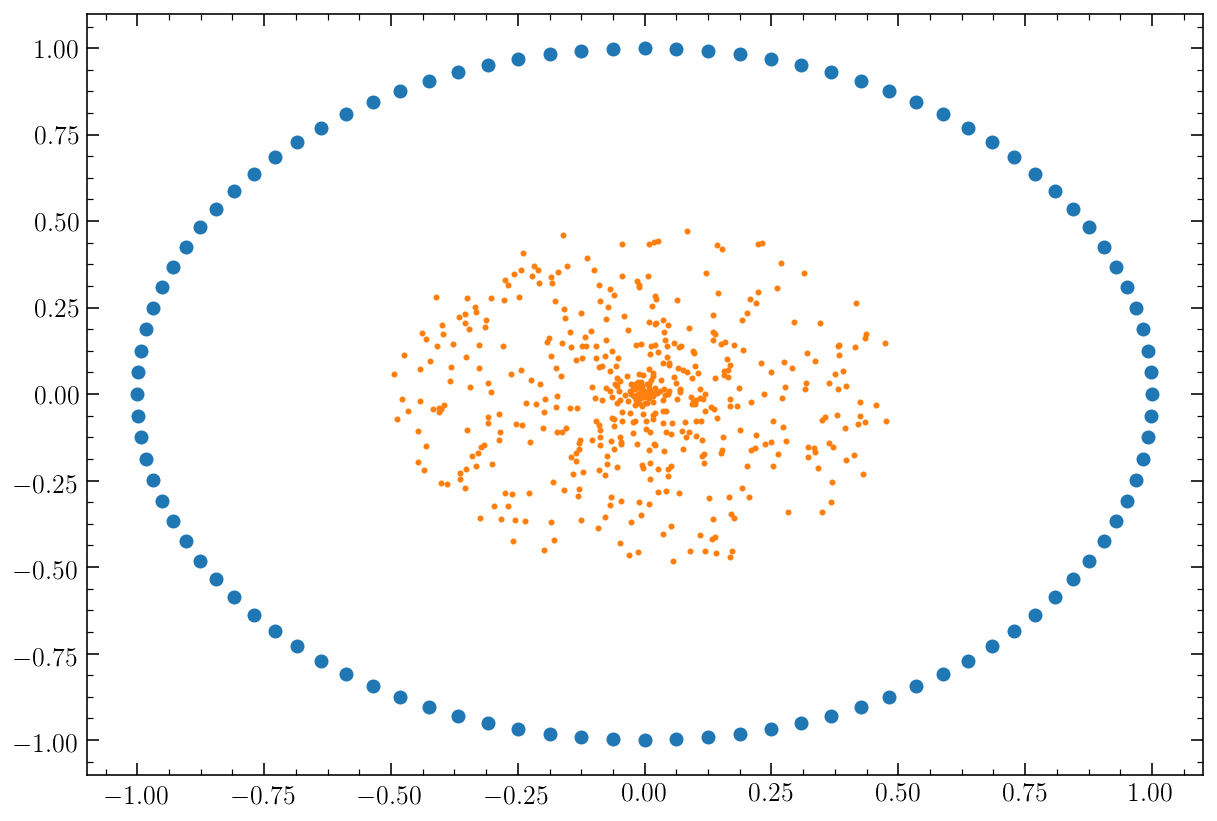

In [11]:
fig, ax = plot_system(ballon, gas)

We can then plot the final state of the system (after all time steps have passed) to see that the ballon has expanded to a steady state where the internal pressure from the gas balances the compressive force from the spring boundary.

(-2.1, 2.1)

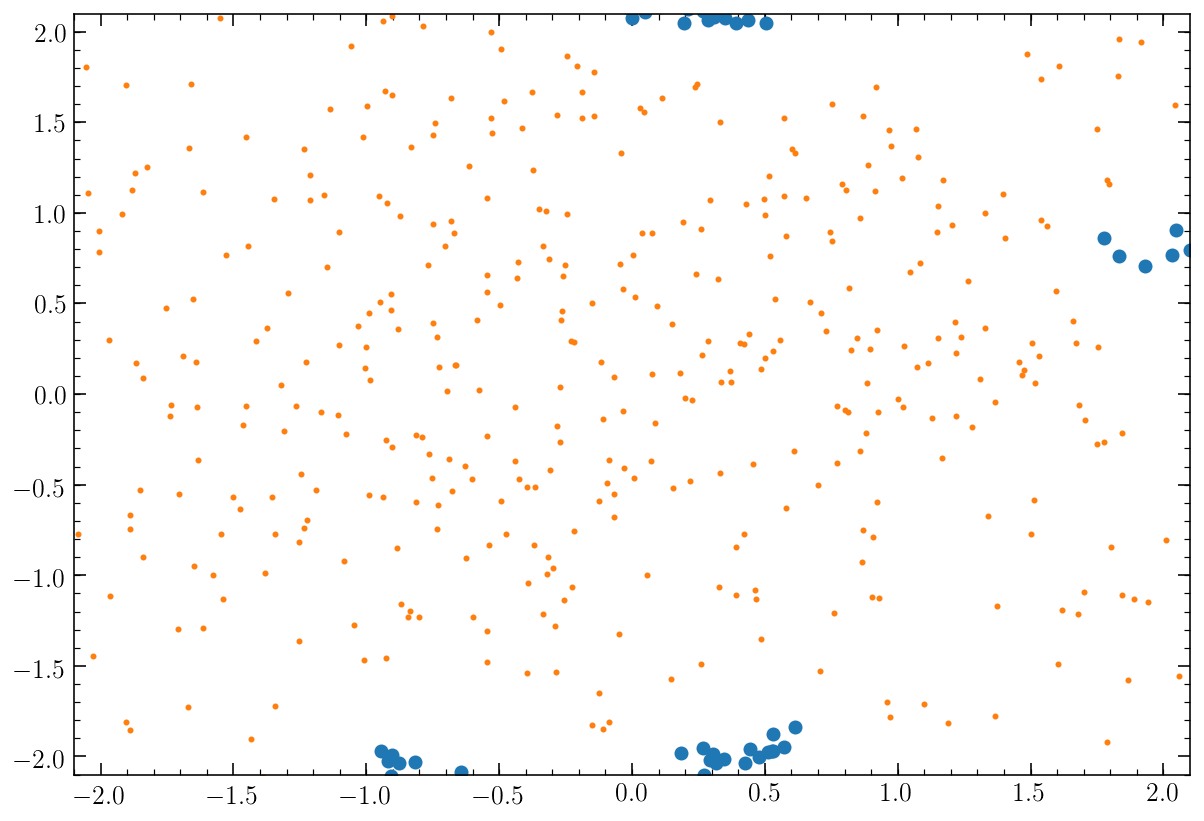

In [12]:
ts = -1
fix, ax = plot_system(yb[ts], yg[ts])
ax.set_xlim(-2.1, 2.1)
ax.set_ylim(-2.1, 2.1)

A better sense of teh time evolution of the system may be gleamed through an animation. I define the following function and use it to animate the simulation.

In [15]:
def animate_integration(yb, yg, name, skip=10):
    anim = animation(name, fps=25)
    for i, (ybt, ygt) in tqdm(enumerate(zip(yb, yg)), total=len(yb)):
        if i % skip == 0:
            fig, ax = plot_system(ybt, ygt)
            ax.set_xlim(-5, 5)
            ax.set_ylim(-5, 5)
            anim.add_frame(fig)
            plt.close(fig)
    anim.close()

In [14]:
from IPython.display import HTML

def playVideo(path):
    return HTML("""
                <video width="320" height="240" controls>
                  <source src="{}" type="video/mp4">
                </video>
                """.format(path))

In [16]:
animate_integration(yb, yg, 'Animations/SteadyStateT=1e-3R=1N=500t=10p2.mp4', skip=1)

100%|██████████| 1001/1001 [02:31<00:00,  6.62it/s]


In [17]:
playVideo('Animations/SteadyStateT=1e-3R=1N=500t=10p2.mp4')

One can note from the video that while the ballon does reach a steady state (It's rate of radius increase levels off, seen more clearly in the graph of radius vs time latter in this notebook) the actual particles comprising the ballon oscillate about each other at a higher and heigher rate as time goes on. The effect of this is that as the simulation is run to longer and longer times the ballon membrane will eventually become unstable (seen past 15 seconds). Future iterations of this work may address this by introducing a dampening force to the connecting springs and/or allowing springs the ballon membrain to break if they seperate too far from their neighbors.

Also note that not all gas particles stay confined to within the ballon. If a particles energy increases sufficiently it may skip over the bondary either inbetween a time step or simply before the spring bound it forms with the boundary has sufficient time to reverse its velocity. This effect is neglibible compared to the number of particles in the simulation (approximatly 0.5% of particles escape) and therefore I neglect it. It may behuve future work to investigate whether this effect may be used as a proxy for the nautral escape of gas particles from ballons.

In order to develope a more quantitative understanding of the behavior of this ballon over time I will investigate both its rate of approximate radius increase along with the evolution of the temperature of the gas particles contained within. The temperature is calculated in the unit system of this simulation as the average kinetic energy of all the gas particles within 10 spatial units of the gas particle center of mass. The Radius is calculated as the average seperation between all pairs of particles $i$, $i+50$ for $i$ from 0 to $49$.

I start by defining some useful, and usable in numba, functions

In [37]:
@njit
def arraysum(a):
    s = 0
    for i in range(a.shape[0]):
        s += a[i]
    return s

In [38]:
@njit
def getcom(y, mass):
    total_mass = arraysum(mass)
    x = np.sum(y[:, 0]*mass)/total_mass
    y = np.sum(y[:, 1]*mass)/total_mass
    com = np.array([x, y, 0])
    return com

In [39]:
@njit
def get_temperature(y, m):
    temp = np.zeros(shape=(y.shape[0],))
    for yt in range(y.shape[0]):
        ptc = 0
        for PID in range(y.shape[1]):
            com = getcom(y[yt, :, :], m)
            r = y[yt, PID, :3]-com
            rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
            if rmag < 10:
                ptc += 1
                v = y[yt, PID, 3:]
                vmag = np.sqrt(v[0]**2+v[1]**2+v[2]**2)
                vhat = v/vmag

                temp[yt] += (1/2)*m[PID]*vmag*vmag
        temp[yt] /= ptc
    return temp

In [40]:
temp = get_temperature(yg, gas_mass)

Text(0.5,0,'Time')

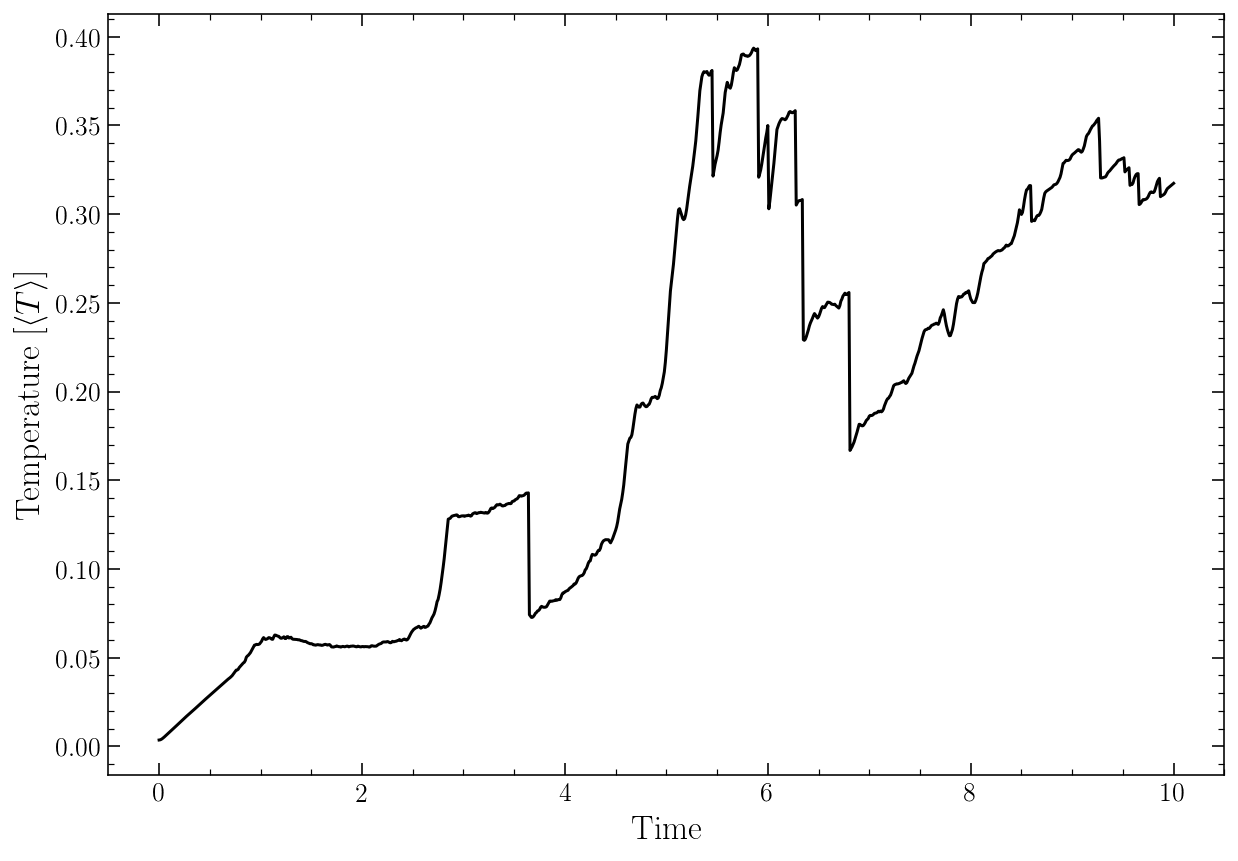

In [41]:
plt.figure(figsize=(10, 7))
plt.plot(t, temp, color='black')
plt.ylabel(r'Temperature [$\left<T\right> $]', fontsize=17)
plt.xlabel(r'Time', fontsize=17)

This temperature plot is a little hard to interpriate, and I belive that future work should improve this and work on using its results to inform further improvments to the model. The initial increase in temerature is consistent with the contraction of the ballon (thus initially compressing the particles and increasing their temperatures; however after this the curve is far more complex, and is clearly formed through a combination of the lenard-jones ineractions, along with the change in avalible area as the ballon grows and shrinks. I also have to investigate why the kinetic energy seams to increase as the volume increases (once the ballon membrane become unstable).

Finally I define a function to calculate the average area, and I graph its results.

In [42]:
def getAverageRadius(y, t):
    avg_radii = np.zeros(shape=(t.shape[0],))
    for TID in range(t.shape[0]):
        radius = 0
        for i in range(int(y[TID].shape[0]/2)):
            p1 = y[TID, i]
            p2 = y[TID, i+int(y[TID].shape[0]/2)]
            r = p2-p1
            rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
            radius += rmag
        radius /= int(y[TID].shape[0]/2)
        avg_radii[TID] = radius
    return avg_radii

In [43]:
radius = getAverageRadius(yb, t)

Text(0.5,0,'Time')

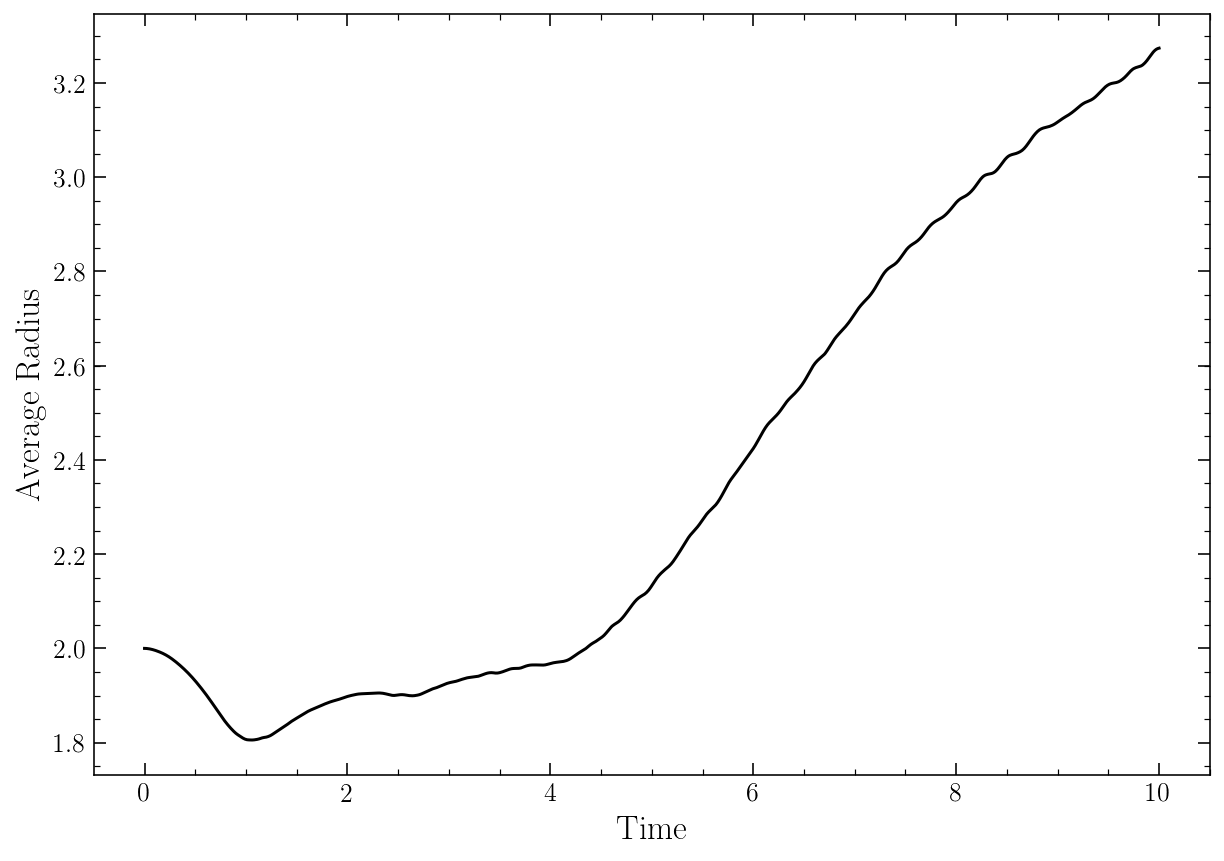

In [44]:
plt.figure(figsize=(10, 7))
plt.plot(t, radius, color='black')
plt.ylabel(r'Average Radius', fontsize=17)
plt.xlabel(r'Time', fontsize=17)

Finally we can plot the derivitive of this to see very clearly that the radius expansion approches a steady state from around 4 time units on. I calcualte the derivitive using a simple difference method. Note how the derivitive approaches zero by 4 time units, thus indicating that its radius is not changing signigigantly.

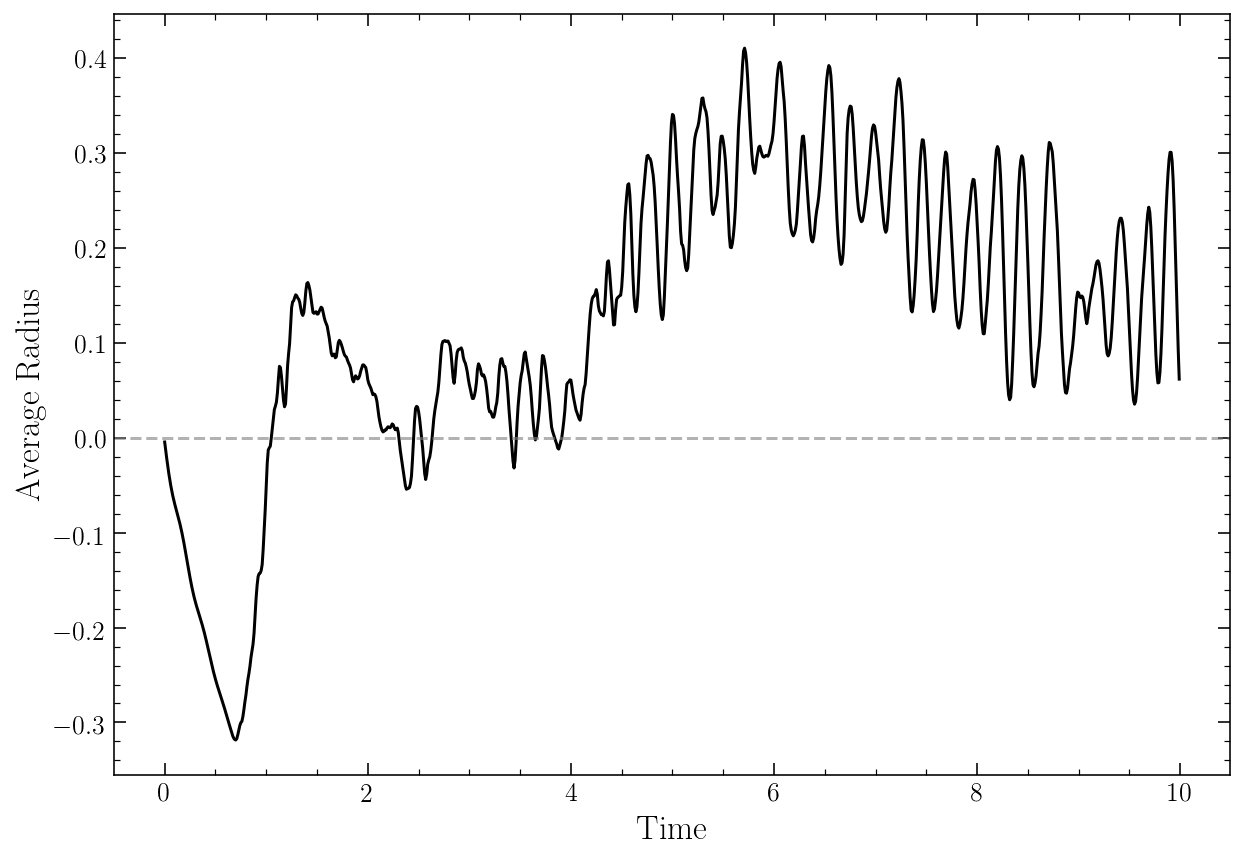

In [45]:
plt.figure(figsize=(10, 7))
plt.plot(t[:-1], (radius[1:]-radius[:-1])/(t[1:]-t[:-1]), color='black')
plt.ylabel(r'Average Radius', fontsize=17)
plt.xlabel(r'Time', fontsize=17)
plt.axhline(y=0, linestyle='dashed', color='grey', alpha=0.6)